In [124]:
import os
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator


def sigzi(x, axis=None):
    return 0.741 * (np.percentile(x, 75, axis=axis) - np.percentile(x, 25, axis=axis))

def plot_loss_over_epochs(train_losses, val_losses, val_mse_losses, finetune_train_losses, finetune_val_losses, finetune_val_mse_losses):
    fig, ax = plt.subplots(3, 2, figsize=(10,15))#, sharey='row')

    epochs = range(1, len(train_losses)+1)
    epochs_finetune = range(1, len(finetune_train_losses)+1)

    # --- Training subplot
    ax[0, 0].plot(epochs, train_losses, label='Train Loss (Huber)', color='blue')
    ax[0, 0].plot(epochs, val_losses, label='Validation Loss (Huber)', color='red')
    #ax1.plot(epochs, val_mse_losses, label='Validation RMSE', color='navy')

    ax[0, 0].set_title('Training Phase')
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].grid(True)
    ax[0, 0].legend()

    # --- Fine-tuning subplot
    ax[0, 1].plot(epochs_finetune, finetune_train_losses, label='Train Loss (MSE)', linestyle='-', color='blue')
    ax[0, 1].plot(epochs_finetune, finetune_val_losses, label='Validation Loss (MSE)', linestyle='-', color='red')
    #ax2.plot(epochs_finetune, finetune_val_mse_losses, label='Validation RMSE', linestyle='--', color='brown')

    ax[0, 1].set_title('Fine-tuning Phase')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].grid(True)
    ax[0, 1].legend()

    ax[1, 0].plot(epochs, val_mse_losses, label='Validation MSE', color='navy')
    ax[1, 0].set_title('Training Phase')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].grid(True)
    ax[1, 0].legend()

    ax[1, 1].plot(epochs_finetune, finetune_val_mse_losses, label='Validation MSE', linestyle='-', color='brown')
    ax[1, 1].set_title('Fine-tuning Phase')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].grid(True)
    ax[1, 1].legend()

    #fig.suptitle('Loss Curves: Training and Fine-tuning', fontsize=16)
    fig.tight_layout()
    return fig, ax

def density_color_mask(x, y, small_size):
    x = np.array(x)
    y = np.array(y)
    xy = (np.vstack([x.ravel(), y.ravel()]))
    if x.shape[0] > small_size:
        small_sample = np.random.choice(range(x.shape[0]), size=small_size)
        z = gaussian_kde(xy[:, small_sample], bw_method='silverman')(xy)
    else:
        z = gaussian_kde(xy, bw_method='silverman')(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x, y, z


def plot_correlation(true, prediction, axis, name="", small_size=15000, true_name="true", limit=None):
    if type(true) is tuple or type(true) is list:
        cmaps = ['Purples', 'Greens', 'Reds', 'Blues', 'Oranges', 'YlOrBr',
                 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu',
                 'PuBuGn', 'BuGn', 'YlGn']
        axis.set_xlabel(xlabel=true_name)
        axis.set_ylabel(ylabel="NN estimated")
        if limit is None:
            limit = (true[0].min(), true[0].max())
        if (type(name) is not list) and (type(name) is not tuple or len(name) == 1):
            name = [str(i) for i in range(len(true))]
        for i in range(len(true)):
            limit = (min(limit[0], min(true[i].min(), prediction[i].min())),
                     max(limit[1], max(true[i].max(), prediction[i].max())))
            t, p, z = density_color_mask(true[i], prediction[i], small_size)
            axis.scatter(np.array(t).flatten(),
                         np.array(p).flatten(),
                         c=z, label=name[i], s=1, cmap=cmaps[i])
    else:
        cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        axis.set_xlabel(xlabel=name + " " + true_name)
        axis.set_ylabel(ylabel=name + " NN estimated")
        if limit is None:
            limit = (min(true.min(), prediction.min()),
                    max(true.max(), prediction.max()))
        t, p, z = density_color_mask(true, prediction, small_size)
        scatter=axis.scatter(np.array(t).flatten(),
                             np.array(p).flatten(),
                             c=z, label=name, s=1, cmap=cmaps[0])
        cbar = plt.colorbar(scatter, ax=axis, pad=0.02)
        cbar.ax.set_ylabel("Points Density", rotation=270, labelpad=-15)
        cbar.set_ticks([z.min(), z.max()])
        cbar.set_ticklabels(['low', 'high'])
    axis.plot([limit[0], limit[1]], [limit[0], limit[1]], c='red', linestyle="dashed", alpha=0.9)
    lgnd = axis.legend(scatterpoints=1, loc='lower right')
    axis.set_facecolor("white")
    limit = (limit[0] - 0.05 * (limit[1] - limit[0]), limit[1] + 0.05 * (limit[1] - limit[0]))
    axis.set(xlim=limit, ylim=limit)
    for i, handle in enumerate(lgnd.legend_handles[0:-1]):
        handle.set_sizes([10.0])
        handle.set_color(matplotlib.cm.get_cmap(cmaps[i])(0.7))
    return axis

def plot_expected_gauss(p, sigma_p, y_test, outputs, ax, mask=None, nbins=300, true_name="true"):
    #p = list(p)
    #sigma_p = list(sigma_p)
    #y_test = list(y_test)
    if mask is not None:
        p = [p[i][mask] for i in range(len(p))]
        sigma_p = [sigma_p[i][mask] for i in range(len(sigma_p))]
        y_test = [y_test[i][mask] for i in range(len(y_test))]
    #fig, ax = plt.subplots(1, 3, figsize=(3 * 5, 5))
    #for i in range(len(ax)):
    ax.set_xlabel(
            r"$\frac{" + outputs + "_{NN} - " + outputs + "_{" + true_name + "}}{ \sigma_{" + outputs + "} }$")
    ax.set_yticks([])
    points_norm = (p[sigma_p != 0] - y_test[sigma_p != 0]) / sigma_p[sigma_p != 0]
    points_norm = points_norm[(points_norm > -3 * sigzi(points_norm)) &
                                  (points_norm < 3 * sigzi(points_norm))]
    hist, bins = np.histogram(points_norm, bins=nbins)
    ax.bar(bins[:-1], hist, width=np.diff(bins))
    norm_x = np.linspace(-3 * sigzi(points_norm), 3 * sigzi(points_norm), 100)
    #norm_x = np.linspace(np.min(points_norm), np.max(points_norm), 100)
    norm_y = scipy.stats.norm.pdf(norm_x, 0, 1) * points_norm.shape[0] * np.diff(bins)[0]
    ax.plot(norm_x, norm_y, color="red", label="N(0,1)")
    ax.legend(loc="upper right")
    return ax

In [122]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.amp import GradScaler, autocast
from IPython.display import Audio, display
import numpy as np

# -------- Load and preprocess data --------
def normalize_x (x, max_time=None, mean_energies=None, std_energies=None):
    times = x[:, :, 0]
    if max_time is None:
        max_time = times.max()
    times_normalized = times / max_time

    energies = x[:, :, 1] * 1e-10
    if mean_energies is None:
        mean_energies = energies.mean()
    if std_energies is None:
        std_energies = energies.std()
    energies_normalized = (energies - mean_energies) / std_energies
    return np.concatenate((times_normalized[:,:, np.newaxis], energies_normalized[:,:, np.newaxis]), axis=-1), max_time, mean_energies, std_energies

def normalize_y (y, min_y=None, max_y=None):
    y = np.log10(y)
    if min_y is None:
        min_y = y.min()
    if max_y is None:
        max_y = y.max()
    y_normalized = (y - min_y) / (max_y - min_y)
    return y_normalized, min_y, max_y

def unnormalize_y (y, min_y, max_y):
    y = y * (max_y - min_y) + min_y
    return y

x_train, y_train = np.load("./Karlo/extra/trainset_p2000n10000_train.npz").values()
x_test, y_test = np.load("./Karlo/extra/trainset_p2000n2500_test.npz").values()
#x_train = x_train[np.log10(y_train[:, -1]) < 22, :, :]
#y_train = y_train[np.log10(y_train[:, -1]) < 22, :]
#x_test = x_test[np.log10(y_test[:, -1]) < 22, :, :]
#y_test = y_test[np.log10(y_test[:, -1]) < 22, :]
x_train, max_time, mean_energies, std_energies = normalize_x(x_train)
x_test, _, _, _ = normalize_x(x_test, max_time, mean_energies, std_energies)

y_train, min_y, max_y = normalize_y(y_train[:, -1])
y_test, _, _ = normalize_y(y_test[:, -1], min_y, max_y)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(x_train_tensor, y_train_tensor) #add a tiny little noise
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, pin_memory=True)

# -------- Transformer model with Positional Encoding --------
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=2000):
        super().__init__()
        position = torch.arange(0, max_len).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, embed_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]  # Match sequence length

class ResidualGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.fc = nn.Linear(dim_in, dim_out * 2)
        self.shortcut = nn.Linear(dim_in, dim_out) if dim_in != dim_out else nn.Identity()
        self.bn = nn.BatchNorm1d(dim_out)

    def forward(self, x):
        residual = self.shortcut(x)
        x_proj, gate = self.fc(x).chunk(2, dim=-1)
        x = x_proj * torch.sigmoid(gate)
        return self.bn(x + residual)

class MultiHeadAttentionPooling(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.query = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, x):
        batch_size = x.size(0)
        query = self.query.repeat(batch_size, 1, 1)  # [batch_size, 1, embed_dim]
        attn_output, attn_weights = self.mha(query, x, x)
        return attn_output.squeeze(1)  # [batch_size, embed_dim]


class LIVTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_layers=4, ff_dim=128, max_len=2000, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=ff_dim, dropout=dropout, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Updated Multi-Head Attention Pooling here:
        self.attn_pool = MultiHeadAttentionPooling(embed_dim, num_heads=num_heads)

        self.head = nn.Sequential(
            ResidualGLU(embed_dim, 128),
            #nn.LeakyReLU(),
            nn.GELU(),
            ResidualGLU(128, 64),
            #nn.LeakyReLU(),
            nn.Softsign(),
            #nn.GELU(),
            ResidualGLU(64, 32),
            #nn.LeakyReLU(),
            nn.Softsign(),
            #nn.GELU(),
            nn.Linear(32, 16),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            #nn.GELU(),
            nn.Linear(16, 8),
            #nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(8, 2),
        )

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding(x)
        x = self.encoder(x)
        x = self.attn_pool(x)
        #return self.head(x).squeeze(-1)
        out = self.head(x)
        mean = out[:, 0]
        var = torch.abs(out[:, 1])

        return torch.stack((mean, var), dim=1)


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def logarithmic_marginal_posterior_density_loss(criterion=None):
    if criterion is None:
            criterion = nn.MSELoss()

    def loss(y_pred, y_true):
        pred_mean = y_pred[:,0]
        pred_var = y_pred[:,1]

        true_mean = y_true
        #moment_loss = criterion(pred_mean, true_mean) + torch.mean(((pred_mean - true_mean) ** 2 - pred_var ** 2)**2)
        moment_loss = torch.log(torch.mean((pred_mean - true_mean) ** 2)) + torch.log(torch.mean(((pred_mean - true_mean) ** 2 - pred_var ** 2)**2))
        return moment_loss
    return loss

def marginal_posterior_density_loss(criterion=None):
    if criterion is None:
            criterion = nn.MSELoss()

    def loss(y_pred, y_true):
        pred_mean = y_pred[:,0]
        pred_var = y_pred[:,1]

        true_mean = y_true
        #moment_loss = criterion(pred_mean, true_mean) + torch.mean(((pred_mean - true_mean) ** 2 - pred_var ** 2)**2)
        #print ("\r", torch.mean(((pred_mean - true_mean) ** 2 - pred_var ** 2)**2).item(), torch.mean((pred_mean - true_mean) ** 2 ).item(), end="")
        moment_loss = torch.mean((pred_mean - true_mean) ** 2 + ((pred_mean - true_mean) ** 2 - pred_var ** 2)**2)
        return moment_loss
    return loss

def gaussian_nll():
    def loss(y_pred, y_true):
        mean = y_pred[:, 0]
        log_var = y_pred[:, 1]  # model should output log variance directly
        precision = torch.exp(-log_var)
        return torch.mean(precision * (y_true - mean)**2 + log_var)
    return loss


def MSE_loss():
    def loss(y_pred, y_true):
        pred_mean = y_pred[:,0]
        pred_var = y_pred[:,1]

        true_mean = y_true
        MSE_loss = nn.MSELoss()(pred_mean, true_mean)
        return MSE_loss
    return loss


def coverage (y_true, y_pred):
    y_true = torch.tensor(y_true)
    mu = torch.tensor(y_pred[:, :1]) # first output neuron
    sig = torch.abs(torch.tensor(y_pred[:, 1:])) # second output neuron
    return torch.mean((torch.abs(y_true-mu)<torch.abs(sig)).to(torch.float))

# -------- Training --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LIVTransformer().to(device)
model.apply(init_weights)

MSEcriterion = MSE_loss()
criterion = marginal_posterior_density_loss(nn.HuberLoss())
#criterion = gaussian_nll()
#criterion = nn.HuberLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-4)
#mean_params = [p for n, p in model.named_parameters() if 'head.6.weight' not in n and 'head.6.bias' not in n]
#var_params = [p for n, p in model.named_parameters() if 'head.6.weight' in n or 'head.6.bias' in n]
#optimizer = torch.optim.Adam([
#    {'params': mean_params, 'lr': 2e-4},
#    {'params': var_params, 'lr': 1e-4}  # Lower LR for variance
#])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=2)

scaler = GradScaler('cuda')

# Early stopping
patience = 20
best_loss = np.inf
trigger_times = 0

train_losses = []
val_losses = []
val_mse_losses = []

for epoch in range(200):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
            #loss = torch.nan_to_num(loss, nan=1e5, posinf=1e5, neginf=-1e5)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    model.eval()
    val_loss = 0.0
    val_MSEloss = 0.0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            y_pred_list.append(pred.cpu().numpy())
            y_true_list.append(yb.cpu().numpy())
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)
    #y_pred[:, 1] = np.exp(y_pred[:, 1])
    cov = coverage(y_true=y_true, y_pred=y_pred)
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()
    if epoch > patience:
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping at epoch", epoch)
                break

    print ()
    print(f"Epoch {epoch+1:03d} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}, Coverage: {cov:.5f}, LR: {scheduler.get_last_lr()[0]:.7f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(np.sqrt(val_MSEloss))


# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# -------- Optional Fine-tuning --------
# Freeze Transformer encoder and retrain only the head
for param in model.encoder.parameters():
    param.requires_grad = False
#criterion = nn.MSELoss()
criterion = marginal_posterior_density_loss(nn.MSELoss())
#criterion = gaussian_nll()
head_params = list(model.head.parameters())
optimizer = torch.optim.Adam([
    {'params': head_params},
], lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

scaler = GradScaler('cuda')

finetune_train_losses = []
finetune_val_losses = []
finetune_val_mse_losses = []


for epoch in range(64):
    train_loss = 0.0
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            pred = model(xb)
            loss = criterion(pred, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        scaler.step(optimizer)
        scaler.update()
        model.eval()
        train_loss += loss.detach().cpu().float().item() * xb.size(0)

    val_loss = 0.0
    val_MSEloss = 0.0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            y_pred_list.append(pred.cpu().numpy())
            y_true_list.append(yb.cpu().numpy())
            loss = criterion(pred, yb)
            MSEloss = MSEcriterion(unnormalize_y(pred, min_y, max_y), unnormalize_y(yb, min_y, max_y))
            val_loss += loss.item() * xb.size(0)
            val_MSEloss += MSEloss.item() * xb.size(0)

    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)
    #y_pred[:, 1] = np.exp(y_pred[:, 1])
    cov = coverage(y_true=y_true, y_pred=y_pred)
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_MSEloss /= len(val_dataset)
    scheduler.step()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Finetune Epoch {epoch+1} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Val MSE: {val_MSEloss:.5f}, Coverage: {cov:.5f}, LR: {scheduler.get_last_lr()[0]:.5f}")
    finetune_train_losses.append(train_loss)
    finetune_val_losses.append(val_loss)
    finetune_val_mse_losses.append(np.sqrt(val_MSEloss))

model.load_state_dict(torch.load("best_model.pt"))

# Process test data in batches
batch_size = 128  # Adjust based on available GPU memory
y_pred_list = []

model.eval()
with torch.no_grad():
    for i in range(0, len(x_test_tensor), batch_size):
        batch = x_test_tensor[i:i + batch_size].to(device)
        batch_pred = model(batch)
        y_pred_list.append(batch_pred.cpu().numpy())

# Concatenate predictions and apply exponential transformation
y_pred = np.concatenate(y_pred_list, axis=0)
#y_pred[:,1] = np.abs(y_pred[:,1])
y_pred[:, 0] = unnormalize_y(y_pred[:, 0], min_y, max_y)
y_pred[:, 1] = y_pred[:, 1] * (max_y - min_y)

#display(Audio(np.sin(2*np.pi*440*np.linspace(0, 1, 44100)), rate=44100, autoplay=True))



Epoch 001 - Train Loss: 0.26909, Val Loss: 0.18884, Val MSE: 15.23815, Coverage: 0.42713, LR: 0.0000996

Epoch 002 - Train Loss: 0.14266, Val Loss: 0.21544, Val MSE: 15.98883, Coverage: 0.21643, LR: 0.0000984

Epoch 003 - Train Loss: 0.09211, Val Loss: 0.13198, Val MSE: 10.81513, Coverage: 0.23882, LR: 0.0000965

Epoch 004 - Train Loss: 0.07155, Val Loss: 0.14952, Val MSE: 11.88268, Coverage: 0.22164, LR: 0.0000938

Epoch 005 - Train Loss: 0.06094, Val Loss: 0.12272, Val MSE: 9.96634, Coverage: 0.10564, LR: 0.0000905

Epoch 006 - Train Loss: 0.05382, Val Loss: 0.12535, Val MSE: 10.07858, Coverage: 0.13039, LR: 0.0000864

Epoch 007 - Train Loss: 0.04800, Val Loss: 0.31249, Val MSE: 21.42156, Coverage: 0.10690, LR: 0.0000819

Epoch 008 - Train Loss: 0.04321, Val Loss: 0.11702, Val MSE: 9.52420, Coverage: 0.15267, LR: 0.0000768

Epoch 009 - Train Loss: 0.04077, Val Loss: 0.21234, Val MSE: 15.09410, Coverage: 0.09273, LR: 0.0000713

Epoch 010 - Train Loss: 0.03795, Val Loss: 0.09538, Val 

/tmp/ipykernel_4644/283520859.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lgnd = axis.legend(scatterpoints=1, loc='lower right')


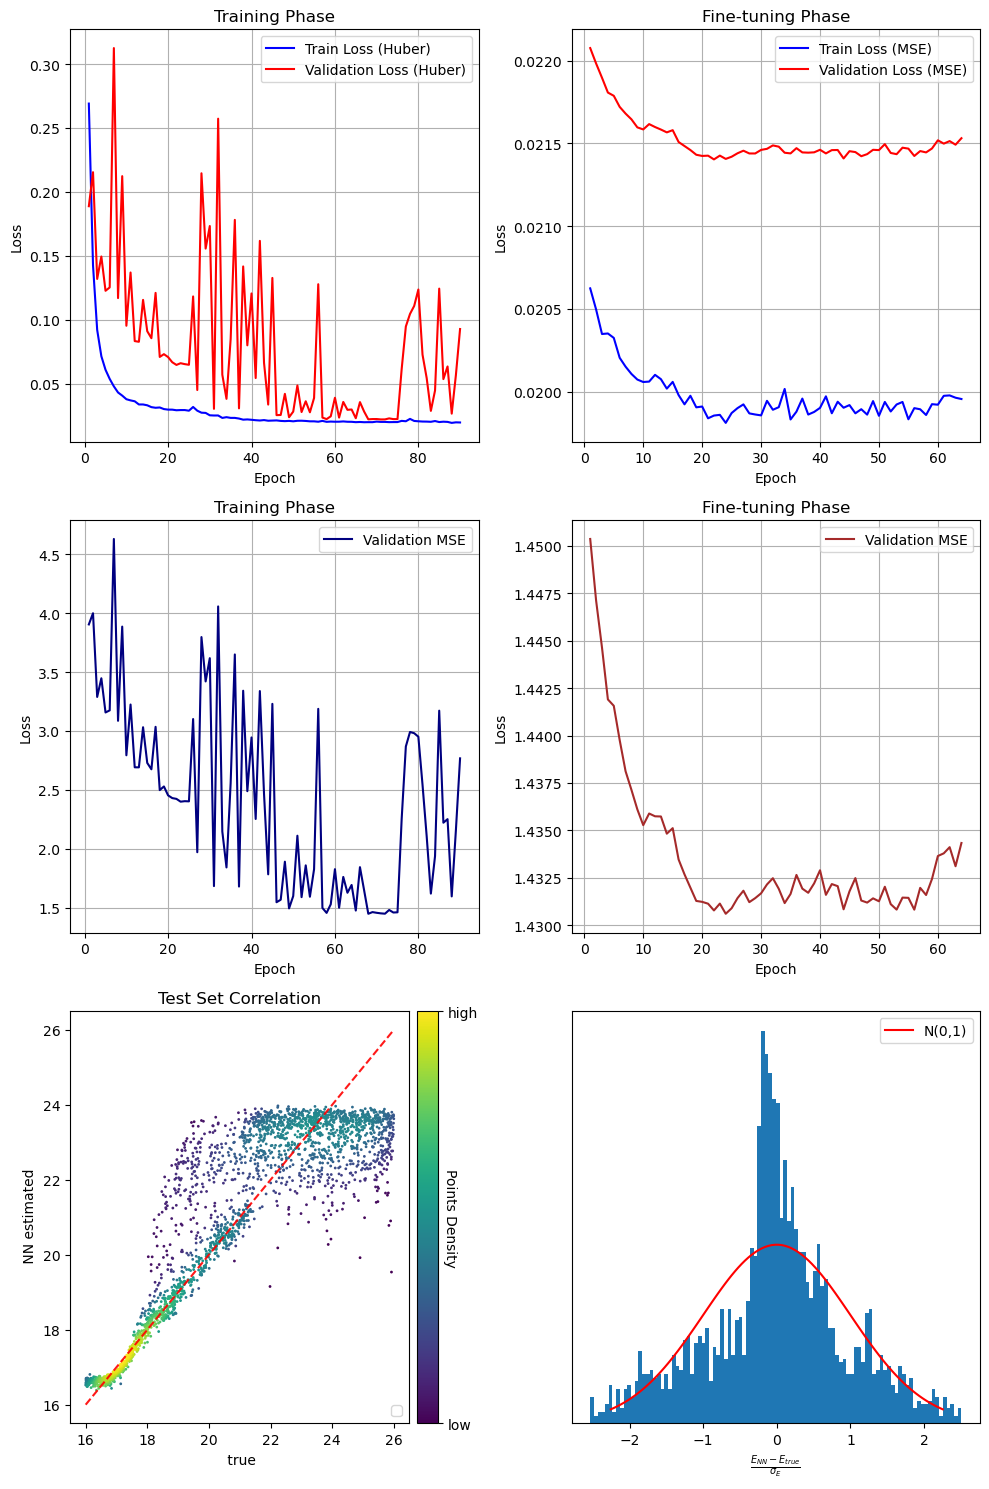

In [126]:
fig, ax = plot_loss_over_epochs(train_losses, val_losses, val_mse_losses, finetune_train_losses, finetune_val_losses, finetune_val_mse_losses)
ax[2, 0] = plot_correlation(unnormalize_y(y_test, min_y, max_y), y_pred[:,0], ax[2, 0])
ax[2, 0].set_title('Test Set Correlation')
ax[2,1] = plot_expected_gauss(y_pred[:,0], y_pred[:,1], unnormalize_y(y_test, min_y, max_y), "E",  ax[2,1], mask=None, nbins=100, true_name="true")
fig.tight_layout()

(array([  1.,   0.,   0.,   0.,   3.,   5.,   8.,   4.,   5.,  13.,   7.,
          8.,   9.,   7.,   7.,   5.,  10.,  13.,  16.,  20.,  27.,  24.,
         29.,  32.,  33.,  29.,  24.,  35.,  18.,  29.,  31.,  34.,  32.,
         31.,  28.,  43.,  50.,  98., 148., 315., 323., 155.,  92.,  59.,
         44.,  28.,  27.,  24.,  28.,  18.,  27.,  22.,  23.,  38.,  26.,
         21.,  27.,  26.,  26.,  30.,  22.,  24.,  20.,  19.,  18.,  11.,
         10.,  12.,  12.,  10.,  10.,   4.,   6.,   8.,   5.,   1.,   1.,
          0.,   1.,   1.,   0.,   1.,   0.,   1.,   2.,   0.,   4.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.23687362, -0.23098876, -0.2251039 , -0.21921903, -0.21333417,
        -0.20744931, -0.20156444, -0.19567958, -0.18979472, -0.18390986,
        -0.17802499, -0.17214013, -0.16625527, -0.1603704 , -0.15448554,
        -0.14860068, -0.14271582, -0.13683095, -0.13094609, -0.12506123,
        -0.11917636, -0.11

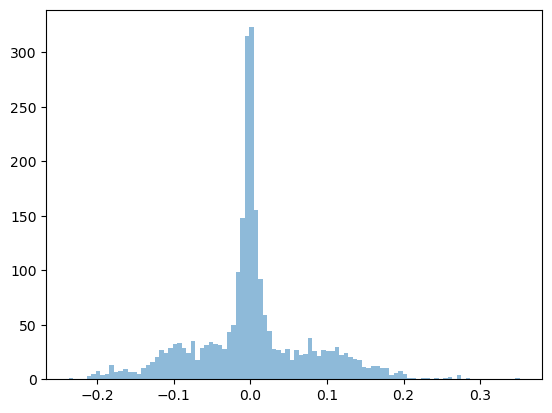

In [70]:
plt.hist((unnormalize_y(y_test, min_y, max_y)-y_pred[:,0])/y_pred[:,1], bins=100, alpha=0.5, label='Predicted')

In [ ]:

def plot_expected_gauss(p, sigma_p, y_test, outputs, mask=None, nbins=300, true_name="true"):
    original_rcparams = matplotlib.rcParams.copy()
    matplotlib.rcParams.update({
        'font.size': 30,  # General font size
        'axes.labelsize': 32,  # X and Y axis label size
        'xtick.labelsize': 18,  # X axis tick size
        'ytick.labelsize': 18,  # Y axis tick size
        'legend.fontsize': 12,  # Legend font size
        'figure.titlesize': 18  # Figure title size
    })
    p = list(p)
    sigma_p = list(sigma_p)
    y_test = list(y_test)
    if mask is not None:
        p = [p[i][mask] for i in range(len(p))]
        sigma_p = [sigma_p[i][mask] for i in range(len(sigma_p))]
        y_test = [y_test[i][mask] for i in range(len(y_test))]
    fig, ax = plt.subplots(1, 3, figsize=(3 * 5, 5))
    for i in range(len(ax)):
        ax[i].set_xlabel(
            r"$\frac{" + outputs[i] + "_{NN} - " + outputs[i] + "_{" + true_name + "}}{ \sigma_{" + outputs[i] + "} }$")
        ax[i].set_yticks([])
        points_norm = (p[i][sigma_p[i] != 0] - y_test[i][sigma_p[i] != 0]) / sigma_p[i][sigma_p[i] != 0]
        points_norm = points_norm[(points_norm > -3 * sigzi(points_norm)) &
                                  (points_norm < 3 * sigzi(points_norm))]
        hist, bins = np.histogram(points_norm, bins=nbins)
        ax[i].bar(bins[:-1], hist, width=np.diff(bins))
        norm_x = np.linspace(-3 * sigzi(points_norm), 3 * sigzi(points_norm), 100)
        norm_y = scipy.stats.norm.pdf(norm_x, 0, 1) * points_norm.shape[0] * np.diff(bins)[0]
        ax[i].plot(norm_x, norm_y, color="red", label="N(0,1)")
        ax[i].legend(loc="upper right")
    matplotlib.rcParams.update(original_rcparams)
    return fig